# Part 2 - Digital Quantum Simulations

by **Francesco Tacchino** and **Dario Gerace** 

<p style='text-align: justify;'> In this chapter, we will use qiskit to program and run the digital quantum simulation of spin Hamiltonians. We will see at work many fundamental concepts, from the well known Trotter digitalization procedure to useful gate decompositions, and we will operatively test the capabilities of a quantum computer in solving the time evolution of a quantum system of interest. Most of the codes in this tutorial can be adapted to run on IBMQ quantum devices with the methods presented in [Part 0-Introduction](./Introduction.ipynb).</p>

<p style='text-align: justify;'> In addition to qiskit, we will use some other well known python tools to do linear algebra calculations and to generate plots. All the required modules are imported below, together with the definition of some standard operators.</p>

In [ ]:
import qiskit as qk
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import math

# Single qubit operators

sx = np.array([[0.0, 1.0],[1.0, 0.0]])
sy = np.array([[0.0, -1.0*1j],[1.0*1j, 0.0]])
sz = np.array([[1.0, 0.0],[0.0, -1.0]])
idt = np.array([[1.0, 0.0],[0.0, 1.0]])

## Simulating quantum physics

<p style='text-align: justify;'> Many physical problems of interest can be modeled in terms of differential equations, with a general linear structure like 
$$
\frac{d\vec{x}}{dt} = M\vec{x}
$$
where $M$ is a matrix and $\vec{x}$ a vector. Once an intial condition $\vec{x}(0)$ is given, the formal solution to the above equation is
$$
\vec{x}(t) = e^{Mt}\vec{x}(0)
$$
In quantum mechanics, the paradigmatic example is the Schrödinger equation (here and in the following, we take $\hbar = 1$)
$$
\frac{d\left|\psi\right\rangle}{dt} = -i\mathcal{H}\left|\psi\right\rangle
$$
where $\mathcal{H}$ is known as the Hamiltonian operator. This complex-valued differential equation is solved by computing the unitary time-evolution operator $\mathrm{U}(t) = e^{-i\mathcal{H}t}$. Indeed, once the latter is known, any initial condition can be evolved linearly as
$$
\left|\psi (t)\right\rangle = \mathrm{U}(t)\left|\psi(0)\right\rangle
$$
Simulating a quantum system relies on the ability to program another device, that we keep under our control, to effectively perform, under a suitable encoding, the operation described by the equation above. Such a task, which in most cases essentially reduces to matrix exponentiation, turns out to be provably diffcult on classical computers, mainly due to the exponential increase of the required time and memory resources with the size of the target quantum system, i.e. the object of our simulation.
</p>

<p style='text-align: justify;'> In 1982, Richard Feynman conjectured that using a controllable quantum mechanical system as a computing resource (instead of a classical object, as your PC is) would provide significant advantages in the simulation of quantum systems (see R. Feynman, Int. J. Theor. Phys. __21__, 467). Indeed, just about fifteen years later, in 1996, Seth Lloyd proved that idea to be essentially correct (see S. Lloyd, Science __273__, 1073), with the sole limitation that the system to be simulated only carries local interactions between its constituent subsystems. In these notes, we will thus concentrate on system Hamiltonians of the form
$$
\mathcal{H} = \sum_l \mathcal{H}_l
$$
where $\mathcal{H}_l$ acts locally only on a portion of the total system.

</p>

### Universal quantum computer as a quantum simulator

<p style='text-align: justify;'> Given a certain Hamiltonian $\mathcal{H}$, the problem of computing the corresponding time evolution operator $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$ is equivalent to the task of implementing a well defined unitary matrix. As it is well known, any quantum computer endowed with a universal set of quantum gates is in principle able to perform any arbitrary unitary transformation, albeit not necessarily in an efficient number of elementary operations. What Lloyd actually proved back in 1996 is precisely that there exist ways for universal quantum computers to compute $\mathrm{U}(t)$ efficiently (i.e. with polynomial time and memory resources in the size of the target system) when $\mathcal{H}$ is a sum of local terms. We will not give here a formal proof of Lloyd's theorem (if you are interested, you can have a look at the original _Science_ paper mentioned in the references), but we will provide some qualitative arguments as a guide for intuition. </p>

<p style='text-align: justify;'> The general idea is based on two fundamental facts: first, in the circuital model for universal quantum computation we can implement general unitary transformations by successively performing elementary unitary operations (_quantum gates_), and appending one unitary $\mathrm{U}_A$ after another $\mathrm{U}_B$ in the circuit results in a total unitary which mathematically is the product $\mathrm{U}_A\mathrm{U}_B$ being applied to the state of the qubit register. Second, any unitary operation $\mathrm{U}$ acting on $N$ qubits can be implemented with $O(2^{2N})$ elementary operations (remember that the dimension of the Hilbert space of $N$ qubits is $d=2^N$). Suppose now that we are given a Hamiltonian which is a sum of local terms
$$
\mathcal{H} = \sum_l^L \mathcal{H}_l
$$
with, say, $L = p\cdot N/2$, where $p$ measures a degree of _locality_ (it can be, for example, the number of nearest neighbors in a lattice, which is the reason why we added a factor 2 in the definition) and $N$ is the total number of qubits required to encode the computation. In general, according to the rules above, computing directly the unitary operator $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$ requires $O(2^{2N})$ operations, and is therefore exponentially inefficient. However, let us call $m_l$ the dimension of the subsystem over which the action of $\mathcal{H}_l$ is restricted. Typically, we will have $m_l \ll 2^N$, since local terms only involve few-body interactions. In this case, the unitary $\mathrm{U}_l(t) = \exp\left(-i\mathcal{H}_lt\right)$ can be computed with $O(m_l^{2})$ operations. The overall product
$$
\prod_l \mathrm{U}_l(t)
$$
can therefore be obtained on a universal quantum computer by juxtaposing the circuit implementations of the single $\mathrm{U}_l(t)$ unitaries and takes at most $O(Lm_{max}^2)$ elementary operations, where $m_{max} = \max_l m_l$. The final step of the reasoning lies in the following mathematical identity, which is known as the Suzuki-Trotter (ST) decomposition:
$$
e^{-i\sum_l \mathcal{H}_l t} = \lim_{n\to\infty} \left(\prod_l e^{-i \mathcal{H}_l t/n}\right)^n
$$
Unless all the $\mathcal{H}_l$ operators commute in the mathematical sense, in which case the ST identity is exact already for $n=1$, the product of local unitaries will not be exactly equal to the total target unitary $\mathrm{U}(t) = \exp\left(-i\mathcal{H}t\right)$. However, it can be shown that $\forall n$
$$
\mathrm{U}(t) = e^{-i\sum_l \mathcal{H}_l t} = \left(\prod_l e^{-i \mathcal{H}_l t/n}\right)^n + O\left(\frac{t^2}{n}\right)
$$
which means that we can approximate arbitrarily well the desired unitary operator by repeating $n$ times the sequence of gates corresponding to the product of local terms for time slices $t/n$. All in all, we were able to break our original problem into smaller pieces $e^{-i \mathcal{H}_l t/n}$ which can now be implemented efficiently using only a limited set of elementary gates and which give the correct answer up to an arbitrarily small _digitalization_ error. Indeed, for any $\epsilon > 0$ and $t$, there exist a $n_\epsilon$ such that $\mathrm{U}(t)$ can be computed within an approximation $\epsilon$ in at most $n_\epsilon Lm_{max}^2$ operations. This is polynomial in $N$ whenever $L = \text{poly}(N)$, as it is for example the case for nearest neighbors interactions.
</p>

### The Suzuki-Trotter formula

<p style='text-align: justify;'> Before proceeding with more specific quantum simulations techniques and examples, let us spend a few more comments on the ST formula which constitutes the fundamental basis of all such applications. An intuitive interpretation of its working principles can be given with two examples. The first one is rather qualitative and was suggested by Lloyd himself in his original paper on quantum simulations. Imagine you want to parallel park your car between two other cars in a space that is just an $\epsilon$ longer than what you need: the best strategy would be to place you car just next to the empty spot, parallel to the sidewalk, and then shift laterally. Unfortunately, no car can normally do such a thing, since it is bound to move only back and forth in arcs with a limited curvature, as much as the quantum computer is bound to perform products of local terms if you want your computation to be efficient. However, as everyone is told in drivng schools, you can always parallel park your car (actually, in a space which is just $\epsilon$ longer than the car itself!) by approximating the required trajectory with many _small_ arc movements. _Mutatis mutandis_, this is exactly what the ST formula is doing for the simulation of our target unitary transformation.  </p>

<p style='text-align: justify;'> More quantitatively, we can show the ST formula at work in a simple case which involves 3d rotations. Indeed, it is not difficult to show that (test it yourself with any object on your desk) finite-angle rotations in space around different coordinate axes do not commute in general. Recalling that the quantum state of a qubit can be mapped into a 3-dimensional unit vector on the Bloch sphere (see [Part 1](./Part1.ipynb)), we can explore the behavior of rotations by applying elementary quantum gates. Imagine for example that we start from the north pole of the Bloch sphere (i.e. the basis state $\left|0\right\rangle$) and we want to perform a rotation around the $x=z$ axis by an angle $\theta$. The corresponding unitary operator is (for single qubit rotations, see Exercise 1.3 in [Part 1](./Part1.ipynb)):
$$
\mathrm{R}_{x=z}(\theta) = \exp\left(-i\frac{\theta}{2}\frac{\sigma_x + \sigma_z}{\sqrt{2}}\right)
$$
The average value of an observable, say $\sigma_x$, on the quantum state $\left|\psi(\theta)\right\rangle=\mathrm{R}_{x=z}(\theta)\left|0\right\rangle$ can be computed for any $\theta$ as
$$
\langle\sigma_x\rangle_\theta = \left\langle\psi(\theta)\right|\sigma_x\left|\psi(\theta)\right\rangle
$$
A plot for this quantity is generated by the code below:
</p>

In [ ]:
psi0 = np.array([1.0, 0.0])
thetas = np.linspace(0,4*math.pi,200)
avg_sx_tot = np.zeros(len(thetas))

for i in range(len(thetas)):
    psi_theta = expm(-1j*0.5*thetas[i]*(sx+sz)/math.sqrt(2)).dot(psi0)
    avg_sx_tot[i] = np.real(psi_theta.conjugate().transpose().dot(sx.dot(psi_theta)))

plt.plot(thetas,avg_sx_tot)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle\sigma_x\rangle_\theta$')
plt.show()

<p style='text-align: justify;'> Suppose now that we want to obtain $\forall\theta$ the same rotation as above, but doing only rotations around the coordinate $x$ and $z$ axes separately. Since $[\sigma_x,\sigma_z]\neq 0$, doing the two full rotations in sequence does not generally give the correct result (the outcome actually depends on whether we rotate first around $z$ or around $x$):
$$
\mathrm{R}_{x=z}(\theta) \neq \exp\left(-i\frac{\theta}{2}\frac{\sigma_x}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2}\frac{\sigma_z}{\sqrt{2}}\right) \neq \exp\left(-i\frac{\theta}{2}\frac{\sigma_z}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2}\frac{\sigma_x}{\sqrt{2}}\right)
$$
</p>

In [ ]:
avg_sx_zx = np.zeros(len(thetas))
avg_sx_xz = np.zeros(len(thetas))

for i in range(len(thetas)):
    psi_theta_zx = expm(-1j*0.5*thetas[i]*(sz)/math.sqrt(2)).dot(expm(-1j*0.5*thetas[i]*(sx)/math.sqrt(2)).dot(psi0))
    psi_theta_xz = expm(-1j*0.5*thetas[i]*(sx)/math.sqrt(2)).dot(expm(-1j*0.5*thetas[i]*(sz)/math.sqrt(2)).dot(psi0))
    avg_sx_zx[i] = np.real(psi_theta_zx.conjugate().transpose().dot(sx.dot(psi_theta_zx)))
    avg_sx_xz[i] = np.real(psi_theta_xz.conjugate().transpose().dot(sx.dot(psi_theta_xz)))

plt.plot(thetas,avg_sx_tot)
plt.plot(thetas,avg_sx_zx)
plt.plot(thetas,avg_sx_xz)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle\sigma_x\rangle_\theta$')
plt.legend(['Around x = z', 'x first', 'z first'],loc=1)
plt.show()

<p style='text-align: justify;'> However, if we follow the ST spirit and we slice the rotations aroud $x$ and $z$ into smaller pieces, repeating such small moves alternatively we can approximate arbitrarily well the desired rotation
$$
\mathrm{R}_{x=z}(\theta) \simeq \left(\exp\left(-i\frac{\theta}{2n}\frac{\sigma_x}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2n}\frac{\sigma_z}{\sqrt{2}}\right)\right)^n \simeq \left(\exp\left(-i\frac{\theta}{2n}\frac{\sigma_z}{\sqrt{2}}\right)\exp\left(-i\frac{\theta}{2n}\frac{\sigma_x}{\sqrt{2}}\right)\right)^n
$$
</p>

In [ ]:
# Try this with e.g. ntrot = 1, 5, 10, 50. 
# You can also try to do sx and sz slices in the reverse order: both choices will become good approximations for large n

ntrot = 10

avg_sx_n = np.zeros(len(thetas))
for i in range(len(thetas)):
    rot = expm(-1j*0.5*thetas[i]*(sx)/(ntrot*math.sqrt(2))).dot(expm(-1j*0.5*thetas[i]*(sz)/(ntrot*math.sqrt(2))))
    for j in range(ntrot-1):
        rot = expm(-1j*0.5*thetas[i]*(sx)/(ntrot*math.sqrt(2))).dot(expm(-1j*0.5*thetas[i]*(sz)/(ntrot*math.sqrt(2)))).dot(rot)
    psi_theta_n = rot.dot(psi0)
    avg_sx_n[i] = np.real(psi_theta_n.conjugate().transpose().dot(sx.dot(psi_theta_n)))
    
plt.plot(thetas,avg_sx_tot)
plt.plot(thetas,avg_sx_n,'--')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\langle\sigma_x\rangle_\theta$')
plt.legend(['Exact', 'ntrot = ' + str(ntrot)],loc=1)
plt.show()

* <p style='text-align: justify;'> __Exercise 2.1__ Choose other observable quantities other than the expectation value of $\sigma_x$ and show in practice that the ST formula applied to the rotation above works also in those cases. Conclude that the formula is valid in general by choosing an appropriate set of observables, i.e. by performing the tomography of the quantum state $\left|\psi(\theta)\right\rangle$. Repeat a similar test in qiskit, using the `statevector_simulator` and the Bloch sphere visualization tools. </p>

## Quantum simulations cookbook

<p style='text-align: justify;'> From now on, we will assume to work with a universal quantum computer, described in the standard circuital model as a (quantum) digital device, i.e. qubit-based and operating with a universal set of quantum gates obeying the algebra of Pauli matrices. The problem of quantum simulation can then be in principle formulated and solved on such a machine by taking a few simple steps. </p>

<p style='text-align: justify;'> __1.__ Define a model Hamiltonian of interest $\mathcal{H}$. The quantum simulation will be efficient, in the sense described above, whenever such $\mathcal{H}$ is the sum of local terms. Notice that this is usually not a limitation in many practical cases, as most physical processes are inherently local in nature.
</p>

<p style='text-align: justify;'> __2.__ Map your target Hamiltonian $\mathcal{H}$ onto its isomorphic representation on the qubit Pauli algebra $\mathrm{SU}(2)$
$$
\mathcal{H}\rightarrow \mathrm{H}(\{\sigma_\alpha\})
$$
In simpler terms, this means finding a suitable encoding of the degrees of freedom of your target system into a number $N$ of qubits (in simple cases $N\simeq \log_2 d$, where $d$ is the dimension of the Hilbert space of the system under study). The resulting mapped Hamiltonian $\mathrm{H}$ will then be written in terms of Pauli matrices. Notice that this mapping is straightforward for physical systems consisting of collections of spin-$1/2$ objects, as they also obey Pauli algebra, but is possible in principle for any physical system (e.g. fermions can be mapped onto qubits with the well known Jordan-Wigner transformation).
</p>

<p style='text-align: justify;'> __3.__ Assuming that we are dealing with the efficiently solvable case in which the target Hamiltonian is a sum of local contributions
$$
\mathcal{H} = \sum_l \mathcal{H}_l \rightarrow \mathrm{H} = \sum_l \mathrm{H}_l
$$
check whether $[\mathrm{H}_l,\mathrm{H}_{l'}] = 0 \,\, \forall l,l'$. If that is the case, then
$$
e^{-i\mathrm{H}t} = \prod_l e^{-i\mathrm{H}_l t}
$$
with no digital error. Otherwise, choose the number of Trotter steps $n$ appropriate for the required degree of precision, in such a way that
$$
e^{-i\mathrm{H}t} \simeq \left(\prod_l e^{-i\mathrm{H}_l t/n}\right)^n
$$
This application of the ST formula is sometimes called _trotterization_ in quantum simulations jargon.
</p>

<p style='text-align: justify;'> __4.__ Translate each local unitary $e^{-i\mathrm{H}_l t}$ (or $e^{-i\mathrm{H}_l t/n}$) into a sequence of quantum gates. This is always possible in at most $O(m_l^2)$ operations and with any universal set of single- and two-qubit operations available on a general purpose quantum computer. The total quantum circuit encoding the time evolution will be the juxtaposition of all the sequences corresponding to the factors in the ST decomposition, repeated (in general) $n$ times.
</p>

<p style='text-align: justify;'> __5.__ Add initial state preparation at the beginning of your circuit and an appropriate set of measurements at the end to recover expectation values of the relevant observables on the evolved quantum state. The part of the circuit encoding for the unitary time evolution must of course be applied between the initialization and measurement stages.
</p>

<p style='text-align: justify;'> The points above represent a quite general set of instructions towards the design of a quantum simulation algorithm. In the following, we will give some explicit examples to show how this is done in practical cases. Of course, such techniques are not limited to actual simulations of real physical systems, but can become a tool for a larger class of computational tasks whenever the problem of interest can be encoded in a Hamiltonian quantum dynamics. </p>

## Quantum simulations of spin-$1/2$ Hamiltonians

<p style='text-align: justify;'> Spin systems are paradimatic examples in many quantum physical applications, from condensed matter to statistical mechanics and beyond. As noticed above, collections of $s=1/2$ spins are among the best candidates for digital quantum simulations, as their Hamiltonians can be mapped straightforwardly on the algebra of qubit registers just by identifying each spin with a single qubit. A paradigmatic lattice spin model with only two-body nearest neighbors interactions takes the form
$$
\mathcal{H} = \sum_{\alpha,\beta}\sum_{\langle i,j\rangle} J'_{ij} \hat{s}_{\alpha}^{(i)}\hat{s}_{\beta}^{(j)} + \sum_{i,\alpha} B'_\alpha g_\alpha \hat{s}_{\alpha}^{(i)}
$$
where $\hat{s}_{\alpha}^{(i)}$ is the $\alpha = x,y,z$ spin component operator for the quantum spin residing in lattice position $i$ and $\langle i,j\rangle$ denotes nearest neighbors pairs. The $J'_{ij}$ measure the spin-spin interactions while the $B'_\alpha g_\alpha$ constants model the coupling of individual spins to an external magnetic field. For the case $s=1/2$, the mapping of $\mathcal{H}$ is straightforward:
$$
\hat{s}_{\alpha}^{(i)}\rightarrow \frac{\sigma_{\alpha}^{(i)}}{2} \quad \forall i = 1,\dots, N
$$
for a system of $N$ spins mapped on $N$ qubits. Assuming for simplicity a lattice with the topology of a chain (the discussion can be easily adapted to other situations) and $B'_\alpha g_\alpha = 2h\delta_{\alpha,z}$, the mapped Hamiltonian takes the general form
$$
\mathrm{H} = \sum_{i=1}^{N-1} J_x \sigma_x^{(i)}\sigma_x^{(i+1)} + J_y \sigma_y^{(i)}\sigma_y^{(i+1)} + J_z \sigma_z^{(i)}\sigma_z^{(i+1)} + h\sigma_z^{(i)}
$$
Many well known physical models are special cases of the Hamiltonian above: for example, when $J_x=J_y=J_z$ we have the isotropic Heisenberg model, while for $J_x=J_y\neq J_z$ we have the XXZ model and for $J_x\neq J_y\neq J_z$ the so-called XYZ model. In the following, we will present a few cases based on the Heisenberg model. The examples include only small numbers of qubits, but they already exhibit all the relevant features of real quantum simulations, including useful gate decompositions and trotterization.
</p>

### Heisenberg model for $N=2$

<p style='text-align: justify;'> In our first practical example, we will perform the digital quantum simulation of the Heisenberg model of a spin $s=1/2$ dimer with zero external field, which can be easily mapped on a quantum register containing $N = 2$ qubits. The target Hamiltonian is
$$
\mathcal{H} = J'\left( \hat{s}_{x}^{(1)}\hat{s}_{x}^{(2)} + \hat{s}_{y}^{(1)}\hat{s}_{y}^{(2)} + \hat{s}_{z}^{(1)}\hat{s}_{z}^{(2)}\right)
$$
Via the identity $\hat{s}_{\alpha}^{(i)}\rightarrow \sigma_{\alpha}^{(i)}/2$, $\mathcal{H}$ is mapped on the qubits as
$$
\mathrm{H} = J\left( \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)
$$
It is straightforward to show (Exercise below) that $[\sigma_\alpha^{(1)}\sigma_\alpha^{(2)},\sigma_\beta^{(1)}\sigma_\beta^{(2)}] = 0 \,\forall \alpha,\beta = x,y,z$ and so the ST formula can be applied exactly with no digital error already with $n = 1$.
</p>

* <p style='text-align: justify;'> __Exercise 2.2__ Prove with explicit matrix calculations that $[\sigma_\alpha^{(1)}\sigma_\alpha^{(2)},\sigma_\beta^{(1)}\sigma_\beta^{(2)}] = 0 \,\forall \alpha,\beta = x,y,z$. </p>

<p style='text-align: justify;'> As a result, the total time evolution that we need to simulate can be decomposed into three separate terms:
$$
e^{-i\mathrm{H}t} = e^{-i\delta \sigma_x^{(1)}\sigma_x^{(2)}}e^{-i\delta \sigma_y^{(1)}\sigma_y^{(2)}}e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
where $\delta = Jt$ is now a dimensionless phase variable. Each one of the factors on the right-hand side of the equation above can be individually seen as a two-qubit unitary operation which can be implemented on the quantum register as a sequence of elementary gates. We will use the universal set of operations containing single qubit rotations and the $\mathrm{CNOT}$ gate, since this is what is natively implemented on the IBMQ devices, but other choices are of course equally valid from a mathematical perspective. The simplest transformation to implement is perhaps the so called $\mathrm{ZZ}(\delta)$:
$$
\mathrm{ZZ}(\delta) = e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
Up to a global phase factor, which can be disregarded when working with quantum states, it corresponds to a combination of two $\mathrm{CNOT}$ gates and a single phase gate (which is called $\mathrm{U}_1(\lambda)$ in qiskit)
$$
\mathrm{ZZ}(\delta) \rightarrow \mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}_{1}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)
$$
In qiskit:
</p>

In [ ]:
delta = 0.1
qr = qk.QuantumRegister(2,name='qr')
zz_example = qk.QuantumCircuit(qr)

zz_example.cx(qr[0],qr[1])
zz_example.u1(2*delta,qr[1])
zz_example.cx(qr[0],qr[1])

zz_example.draw(output='mpl')

* <p style='text-align: justify;'> __Exercise 2.3__ Verify the decomposition of $\mathrm{ZZ}(\delta)$ explicitly with mathematical calculations and find the global phase factor relating $e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}$ and $\mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}_{1}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)$.

<p style='text-align: justify;'> Now that we know how to encode the $\mathrm{ZZ}(\delta)$ transformation, we can use it as a building block to obtain the other two factors in the decomposition of the target time evolution operator, namely
$$
\mathrm{XX}(\delta) = e^{-i\delta \sigma_x^{(1)}\sigma_x^{(2)}}
$$
and
$$
\mathrm{YY}(\delta) = e^{-i\delta \sigma_y^{(1)}\sigma_y^{(2)}}
$$
Indeed, these have exactly the same structure of the $\mathrm{ZZ}(\delta)$ transformation but operate along different directions ($x$ or $y$ instead of $z$). A rotation of the reference frame can therefore be used to map both transformations back to the $\mathrm{ZZ}$ one. The idea is based on the following mathematical identities between Pauli matrices and single qubit rotations
$$
\mathrm{R}_y(-\pi/2)\sigma_z \mathrm{R}_y(\pi/2) = \sigma_x
$$
$$
\mathrm{R}_x(-\pi/2)\sigma_z \mathrm{R}_x(\pi/2) = -\sigma_y
$$
which basically translate the geometrical fact that a rotation of the $z$ axis around the $x$ or $y$ axis by an angle $\pm \pi/2$ brings $z$ itself onto $y$ or $x$ respectively. As a result, we can obtain the same action of, say, the operator $\sigma_x$ by rotating around $y$ first, then applying $\sigma_z$ and finally rotating back to the original reference frame. If we apply the change in reference frame in parallel to both qubits in our quantum register, we can therefore easily obtain
$$
\mathrm{XX}(\delta) = \left(\mathrm{R}_y(-\pi/2)\otimes \mathrm{R}_y(-\pi/2)\right) \mathrm{ZZ}(\delta) \left(\mathrm{R}_y(\pi/2)\otimes \mathrm{R}_y(\pi/2)\right)
$$
and
$$
\mathrm{YY}(\delta) = \left(\mathrm{R}_x(-\pi/2)\otimes \mathrm{R}_x(-\pi/2)\right) \mathrm{ZZ}(\delta) \left(\mathrm{R}_x(\pi/2)\otimes \mathrm{R}_x(\pi/2)\right)
$$
The overall sequence required to simulate the Heisenberg dimer is therefore
$$
e^{-i\mathrm{H}t} = \mathrm{XX}(\delta)\mathrm{YY}(\delta)\mathrm{ZZ}(\delta)
$$
We can see it at work in qiskit by adding at the end of the circuit a measurement in the computational basis. This will provide us with an estimate of the probabilities $p_0^{(i)},p_1^{(i)}$ of finding each qubit in one of the two eigenstates of $\sigma_z$ (i.e. $\left|0\right\rangle$ and $\left|1\right\rangle$) and therefore with an estimate of the average spin magnetization along the $z$ direction
$$
\left\langle\hat{s}^{(i)}_z(t)\right\rangle = \frac{1}{2}\left\langle\psi (t)\right|\sigma^{(i)}_z(t)\left|\psi(t)\right\rangle = \frac{1}{2}\left(+1 \cdot p_0^{(i)} -1\cdot p_1^{(i)}\right)
$$
where $\left|\psi(t)\right\rangle = U(t)\left|\psi (0)\right\rangle$ is the time evolved state of the two qubits. In order to obtain a non-trivial time evolution for $\left\langle\hat{s}^{(i)}_z(t)\right\rangle$, we will start from the initial state
$$
\left|\psi (0) \right\rangle = \left|1\right\rangle \otimes \left|0\right\rangle
$$
You can find below the python code that compares the classical simulation of the Heisenberg dimer model with standard linear algebra techniques and the corresponding digital quantum simulation. Take a moment to understand the code, to play around with the parameters (including the number of repetitions of the quantum sequence) and to appreciate the agreement between the two techniques.  
</p>

In [ ]:
J = 1
c_times = np.linspace(0,0.5*math.pi/abs(J),1000)
q_times = np.linspace(0,0.5*math.pi/abs(J),10)

### Classical simulation of the Heisenberg dimer model

psi0 = np.kron( np.array([0,1]), np.array([1,0]) )
H = J * ( np.kron(sx,sx) + np.kron(sy,sy) + np.kron(sz,sz) )

sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))

sz1 = np.kron(sz,idt)
sz2 = np.kron(idt,sz)

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = expm(-1j*H*t).dot(psi0)
    sz1_t[i] = np.real(psi_t.conjugate().transpose().dot(sz1.dot(psi_t)))
    sz2_t[i] = np.real(psi_t.conjugate().transpose().dot(sz2.dot(psi_t)))

### Digital quantum simulation of the Heisenberg dimer model using qiskit

nshots = 1024

sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))

for k in range(len(q_times)):
    
    delta = J*q_times[k]
    
    qr = qk.QuantumRegister(2,name='qr')
    cr = qk.ClassicalRegister(2,name='cr')
    Heis2 = qk.QuantumCircuit(qr,cr)
    
    # Initial state preparation
    
    Heis2.x(qr[0])
    
    # ZZ
    
    Heis2.cx(qr[0],qr[1])
    Heis2.u1(-2*delta,qr[1])
    Heis2.cx(qr[0],qr[1])
    
    # YY
    
    Heis2.u3(math.pi/2, -math.pi/2, math.pi/2, qr[0])
    Heis2.u3(math.pi/2, -math.pi/2, math.pi/2, qr[1])
    Heis2.cx(qr[0],qr[1])
    Heis2.u1(-2*delta,qr[1])
    Heis2.cx(qr[0],qr[1])
    Heis2.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[0])
    Heis2.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[1])
    
    # XX
    
    Heis2.u3(-math.pi/2, 0.0, 0.0, qr[0])
    Heis2.u3(-math.pi/2, 0.0, 0.0, qr[1])
    Heis2.cx(qr[0],qr[1])
    Heis2.u1(-2*delta,qr[1])
    Heis2.cx(qr[0],qr[1])
    Heis2.u3(math.pi/2, 0.0, 0.0, qr[0])
    Heis2.u3(math.pi/2, 0.0, 0.0, qr[1])
    
    # measure
    
    Heis2.measure(qr,cr)
    
    # Run the quantum algorithm
    
    backend = qk.BasicAer.get_backend('qasm_simulator')
    job = qk.execute(Heis2, backend, shots=nshots)
    result = job.result()
    counts = result.get_counts()

    # Post processing of outcomes to get sz expectation values
    
    sz1q = 0
    sz2q = 0
    for key,value in counts.items():
        if key == '00':
            sz1q += value
            sz2q += value
        elif key == '01':
            sz1q -= value
            sz2q += value
        elif key == '10':
            sz1q += value
            sz2q -= value
        elif key == '11':
            sz1q -= value
            sz2q -= value
    
    sz1q_t[k] = sz1q/nshots
    sz2q_t[k] = sz2q/nshots


plt.plot(abs(J)*c_times,0.5*sz1_t,'b--')
plt.plot(abs(J)*c_times,0.5*sz2_t,'c')
plt.plot(abs(J)*q_times,0.5*sz1q_t,'rd')
plt.plot(abs(J)*q_times,0.5*sz2q_t,'ko')
plt.legend(['sz1','sz2','sz1q','sz2q'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()


* <p style='text-align: justify;'> __Exercise 2.4 (Heisenberg dimer with magnetic field)__ Consider an external magnetic field along the $x$ direction acting on the spin dimer, with equivalent strength on the two spins, such that the total mapped Hamiltonian becomes:
$$
\mathrm{H} = J\left( \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) + h \left( \sigma_x^{(1)} + \sigma_x^{(2)}\right)
$$
After verifiyng that a digital quantum simulation with $n=1$ Trotter steps is still possible, update the qiskit code in the example above (and its classical counterpart) to compute the time evolution of the spin magnetization under this condition. </p>
  
  
* <p style='text-align: justify;'> __Exercise 2.5 (More efficient quantum algorithm for the Heisenberg dimer)__ The sequence described above for the simulation of the Heisenberg dimer, albeit quite convenient for educational purposes, is not the most efficient one in terms of total number of two-qubit operations. Indeed, all the blocks ($\mathrm{ZZ}$,$\mathrm{YY}$ and $\mathrm{XX}$) commute and are essentially part of the _same_ local term, acting on just two qubits. One could therefore think of directly decomposing the total two-qubit unitary transformation $e^{-i\mathrm{H}t} = e^{-i\delta \left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)}$ into a sequence of $\mathrm{CNOT}$s and single qubit rotations, and this turns out to be a more efficient strategy, even though a litte less transparent. Try to find and implement in qiskit such quantum algorithm for the simulation of the Heisenberg dimer using only _three_ (instead of six) $\mathrm{CNOT}$s, together with a few single qubit rotations. (_hint_: check Vidal and Dawson, _Phys. Rev. A_ __69__, 010301(R) (2004) for some useful mathematical proofs).</p>

### Heisenberg model for $N=3$

<p style='text-align: justify;'> Now that we know how to simulate a block of two spins $s = 1/2$ interacting with a Heisenberg-type Hamiltonian, we can generalize the algorithm to chains of arbitrary length. We will show explicitly the the simple case with three spins mapped onto $N=3$ qubits, and then it will be up to the reader to scale up.</p>

<p style='text-align: justify;'> Suppose we are given a chain of three spin-$1/2$ systems, pairwise interacting with a Heisenberg-like Hamiltonian. Along the 1-2 _bond_ of such _magnetic molecule_ the Hamiltonian is
$$
\mathcal{H}_{12} = J_{12}'\left( \hat{s}_{x}^{(1)}\hat{s}_{x}^{(2)} + \hat{s}_{y}^{(1)}\hat{s}_{y}^{(2)} + \hat{s}_{z}^{(1)}\hat{s}_{z}^{(2)}\right)
$$
while the contribution of the 2-3 bond is
$$
\mathcal{H}_{23} = J_{23}'\left( \hat{s}_{x}^{(2)}\hat{s}_{x}^{(3)} + \hat{s}_{y}^{(2)}\hat{s}_{y}^{(3)} + \hat{s}_{z}^{(2)}\hat{s}_{z}^{(3)}\right)
$$
The total Hamiltonian is therefore the sum of two different local terms
$$
\mathcal{H} = \mathcal{H}_{12} + \mathcal{H}_{23}
$$
Just like in the case of a Heisenberg dimer described above, the target Hamiltonian can be encoded one-to-one onto a quantum register of three qubits, thus obtaining a mapped Hamiltonian
$$
\mathrm{H} = J_{12}\left( \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) + J_{23}\left( \sigma_x^{(2)}\sigma_x^{(3)} + \sigma_y^{(2)}\sigma_y^{(3)} + \sigma_z^{(2)}\sigma_z^{(3)}\right)
$$
According to the general recipe for digital quantum simulations, we can split the total time evolution of the system in the product of the local time evolution terms. For each of them, we can then apply the techniques and the circuit decompositions already developed for the Heisenberg dimer. However, regardless of the values of $J_{12}$ and $J_{23}$, the two local terms $\mathrm{H}_{12}$ and $\mathrm{H}_{23}$ _do not_ commute, due to the presence of non-commuting Pauli operators for the "(2)" spin in both Hamiltonians. As a result, our digital quantum simulation requires a non-trivial application of the Suzuki-Trotter decomposition and will be affected by a digital error:
$$
e^{-i\mathrm{H}t} \simeq \left(e^{-i\mathrm{H}_{12}t/n}e^{-i\mathrm{H}_{23}t/n}\right)^n = \left(\mathrm{XX}_{12}(\delta_{12}/n)\mathrm{YY}_{12}(\delta_{12}/n)\mathrm{ZZ_{12}}(\delta_{12}/n)\mathrm{XX}_{23}(\delta_{23}/n)\mathrm{YY}_{23}(\delta_{23}/n)\mathrm{ZZ_{23}}(\delta_{23}/n)\right)^n
$$
where $\delta_{lm} = J_{lm}t$ and say $\mathrm{XX}_{lm}$ is the $\mathrm{XX}$ gate sequence applied to qubits $l$ and $m$. Below, we provide the comparison between a classical linear-algebra exact solution of the Heisenberg chain time evolution, a classical solution of the _approximated_ version using the ST formula and the digital quantum simulation of the model in qiskit. You can once again play with the parameters to see, in particular, how the digital error, i.e. the discrepancy between the exact solution and the digitalized ones (both classical linear algebra-based and quantum), decreases with $n$.
</P>

In [ ]:
# WARNING: this cell can take a few minutes to run!

ntrotter = 5

J12 = 1
J23 = 1
c_times = np.linspace(0,math.pi/abs(J12),1000)
q_times = np.linspace(0,math.pi/abs(J12),20)

### Classical simulation of the Heisenberg trimer model

psi0 = np.kron( np.kron( np.array([0,1]), np.array([1,0]) ) , np.array([1,0]) )

sxsx12 = np.kron(sx, np.kron(sx,idt))
sysy12 = np.kron(sy, np.kron(sy,idt))
szsz12 = np.kron(sz, np.kron(sz,idt))

sxsx23 = np.kron(idt, np.kron(sx,sx))
sysy23 = np.kron(idt, np.kron(sy,sy))
szsz23 = np.kron(idt, np.kron(sz,sz))

H12 = J12 * ( sxsx12 + sysy12 + szsz12 )
H23 = J23 * ( sxsx23 + sysy23 + szsz23 )
H =  H12 + H23

sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))
sz3_t = np.zeros(len(c_times))

sz1 = np.kron(sz, np.kron(idt,idt))
sz2 = np.kron(idt, np.kron(sz,idt))
sz3 = np.kron(idt, np.kron(idt,sz))

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = expm(-1j*H*t).dot(psi0)
    sz1_t[i] = np.real(psi_t.conjugate().transpose().dot(sz1.dot(psi_t)))
    sz2_t[i] = np.real(psi_t.conjugate().transpose().dot(sz2.dot(psi_t)))
    sz3_t[i] = np.real(psi_t.conjugate().transpose().dot(sz3.dot(psi_t)))
    
### Classical simulation of the Heisenberg trimer model WITH SUZUKI TROTTER DIGITALIZATION

sz1st_t = np.zeros(len(c_times))
sz2st_t = np.zeros(len(c_times))
sz3st_t = np.zeros(len(c_times))

for i in range(len(c_times)):
    
    t = c_times[i]
    Ust = expm(-1j*H23*t/ntrotter).dot(expm(-1j*H12*t/ntrotter))
    for j in range(ntrotter-1):
        Ust = expm(-1j*H23*t/ntrotter).dot(expm(-1j*H12*t/ntrotter)).dot(Ust)
    psi_t = Ust.dot(psi0)
    sz1st_t[i] = np.real(psi_t.conjugate().transpose().dot(sz1.dot(psi_t)))
    sz2st_t[i] = np.real(psi_t.conjugate().transpose().dot(sz2.dot(psi_t)))
    sz3st_t[i] = np.real(psi_t.conjugate().transpose().dot(sz3.dot(psi_t)))

    
### Digital quantum simulation of the Heisenberg model using qiskit

nshots = 1024

sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))
sz3q_t = np.zeros(len(q_times))

for k in range(len(q_times)):
    
    delta12n = J12*q_times[k]/ntrotter
    delta23n = J23*q_times[k]/ntrotter
    
    qr = qk.QuantumRegister(3,name='qr')
    cr = qk.ClassicalRegister(3,name='cr')
    Heis3 = qk.QuantumCircuit(qr,cr)
    
    # Initial state preparation
    
    Heis3.x(qr[0])
    
    for n in range(ntrotter):
        
        # 1-2 bond mapped on qubits 0 and 1 in the quantum register
        
        # ZZ
    
        Heis3.cx(qr[0],qr[1])
        Heis3.u1(-2*delta12n,qr[1])
        Heis3.cx(qr[0],qr[1])
    
        # YY
    
        Heis3.u3(math.pi/2, -math.pi/2, math.pi/2, qr[0])
        Heis3.u3(math.pi/2, -math.pi/2, math.pi/2, qr[1])
        Heis3.cx(qr[0],qr[1])
        Heis3.u1(-2*delta12n,qr[1])
        Heis3.cx(qr[0],qr[1])
        Heis3.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[0])
        Heis3.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[1])
    
        # XX
    
        Heis3.u3(-math.pi/2, 0.0, 0.0, qr[0])
        Heis3.u3(-math.pi/2, 0.0, 0.0, qr[1])
        Heis3.cx(qr[0],qr[1])
        Heis3.u1(-2*delta12n,qr[1])
        Heis3.cx(qr[0],qr[1])
        Heis3.u3(math.pi/2, 0.0, 0.0, qr[0])
        Heis3.u3(math.pi/2, 0.0, 0.0, qr[1])
        
        # 2-3 bond mapped on qubits 1 and 2 in the quantum register
        
        # ZZ
    
        Heis3.cx(qr[1],qr[2])
        Heis3.u1(-2*delta12n,qr[2])
        Heis3.cx(qr[1],qr[2])
    
        # YY
    
        Heis3.u3(math.pi/2, -math.pi/2, math.pi/2, qr[1])
        Heis3.u3(math.pi/2, -math.pi/2, math.pi/2, qr[2])
        Heis3.cx(qr[1],qr[2])
        Heis3.u1(-2*delta12n,qr[2])
        Heis3.cx(qr[1],qr[2])
        Heis3.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[1])
        Heis3.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[2])
    
        # XX
    
        Heis3.u3(-math.pi/2, 0.0, 0.0, qr[1])
        Heis3.u3(-math.pi/2, 0.0, 0.0, qr[2])
        Heis3.cx(qr[1],qr[2])
        Heis3.u1(-2*delta12n,qr[2])
        Heis3.cx(qr[1],qr[2])
        Heis3.u3(math.pi/2, 0.0, 0.0, qr[1])
        Heis3.u3(math.pi/2, 0.0, 0.0, qr[2])
    
    # measure
    
    Heis3.measure(qr,cr)
    
    # Run the quantum algorithm
    
    backend = qk.BasicAer.get_backend('qasm_simulator')
    job = qk.execute(Heis3, backend, shots=nshots)
    result = job.result()
    counts = result.get_counts()

    # Post processing of outcomes to get sz expectation values

    sz1q = 0
    sz2q = 0
    sz3q = 0
    for key,value in counts.items():
        if key == '000':
            sz1q += value
            sz2q += value
            sz3q += value
        elif key == '001':
            sz1q -= value
            sz2q += value
            sz3q += value
        elif key == '010':
            sz1q += value
            sz2q -= value
            sz3q += value
        elif key == '011':
            sz1q -= value
            sz2q -= value
            sz3q += value
        elif key == '100':
            sz1q += value
            sz2q += value
            sz3q -= value
        elif key == '101':
            sz1q -= value
            sz2q += value
            sz3q -= value
        elif key == '110':
            sz1q += value
            sz2q -= value
            sz3q -= value
        elif key == '111':
            sz1q -= value
            sz2q -= value
            sz3q -= value
    
    sz1q_t[k] = sz1q/nshots
    sz2q_t[k] = sz2q/nshots
    sz3q_t[k] = sz3q/nshots

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(abs(J12)*c_times,0.5*sz1_t,'b', label='sz1 full')
ax.plot(abs(J12)*c_times,0.5*sz2_t,'r', label='sz2 full')
ax.plot(abs(J12)*c_times,0.5*sz3_t,'g', label='sz3 full')
ax.plot(abs(J12)*c_times,0.5*sz1st_t,'b--',label='sz1 n = ' + str(ntrotter) + ' (classical)')
ax.plot(abs(J12)*c_times,0.5*sz2st_t,'r--', label='sz2 n = ' + str(ntrotter) + ' (classical)')
ax.plot(abs(J12)*c_times,0.5*sz3st_t,'g--', label='sz3 n = ' + str(ntrotter) + ' (classical)')
ax.plot(abs(J12)*q_times,0.5*sz1q_t,'b*',label='sz1 n = ' + str(ntrotter) + ' (quantum)')
ax.plot(abs(J12)*q_times,0.5*sz2q_t,'ro', label='sz2 n = ' + str(ntrotter) + ' (quantum)')
ax.plot(abs(J12)*q_times,0.5*sz3q_t,'gd', label='sz3 n = ' + str(ntrotter) + ' (quantum)')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
plt.xlabel(r'$\delta_{12} = |J_{12}|t$')
plt.show()

<p style='text-align: justify;'> Before concluding, let us make a few other useful remarks about the digital quantum simulation of spin chains:</p>

* <p style='text-align: justify;'> Since in the simulation of the Heisenberg trimer above $\mathrm{H}_{12}$ and $\mathrm{H}_{23}$ do not commute, for any finite $n$ doing the 1-2 part of the sequence before the 2-3 part or viceversa is not exactly equivalent, and can result in smaller or larger digital errors on specific observable quantities. More in general, this is usually true whenever non-commuting local terms are involved.</p>
* <p style='text-align: justify;'> When working on digital quantum simulations of spin chains featuring different number of sub-systems and different chain topologies, one should notice that, as shown in the $N=3$ example above, all bonds with common ends (e.g. 1-2 and 2-3) correspond in general to non-commuting local terms in the Hamiltonian. However, all bonds with no common ends will be independent of each other and their corresponding contributions to the total Hamiltonian will commute. As a consequence, the parts of the quantum algorithm encoding for such commuting portions of the Hamiltonian, if mapped on independent set of qubits, can be executed in parallel even within a single Suzuki-Trotter step, thus resulting in a more efficient scaling of the total length of the quantum circuit. </p>
* <p style='text-align: justify;'> More refined versions of the ST decomposition are known, with sometimes better scaling properties of the digital error. An example is the so called _second order_ formula
$$
e^{-i(H_1 + H_2)t} = \left(e^{-iH_1t/(2n)}e^{-iH_2t/n}e^{-iH_1t/(2n)}\right)^n + O\left(\frac{t^3}{n^2}\right)
$$
* <p style='text-align: justify;'> It may seem, from the simulations presented above, that the digitalization error is for all practical purposes just a matter of adding a `for` cycle in your quantum code. However, one should keep in mind that, especially in the age of Noisy Intermediate Scale Quantum (NISQ) processors, longer sequences mean longer execution times and heavier exposure to _physical_ noise and errors on the qubits. As a matter of fact, there is today a reasonable limit in the total number of gates that can be executed on a real processor without affecting too much the quality of the final results. A careful balance between mathematical errors arising from the ST decomposition and the hardware-level errors is extremely important: while the absence of full error correction still limits the power of the processors themselves, it is nevertheless already possible to perform remarkable (and funny!) proof-of-principle quantum simulations. These could in turn become a very valuable asset whenever a next generation of processors, with a larger number of qubits even if still error-prone, will eventually show a quantum advantage in computational power with respect to all classical counterparts.
</p>

## Exercises

* <p style='text-align: justify;'> __Exercise 2.6 (Heisenberg dimer with inequivalent ions)__ Use qiskit to perform the digital quantum simulation of the Heisenberg dimer of spin $s=1/2$ in the presence of a magnetic field acting non uniformly  on the two spins:
$$
\mathrm{H} = J\left( \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) + h_1 \sigma_x^{(1)} + h_2 \sigma_x^{(2)}
$$
Measure the time evolution of the spin component along the $z$ direction and compare your results with the corresponding classical simulation using linear algebra techniques.
</p>

* <p style='text-align: justify;'> __Exercise 2.7 (Heisenberg on XY hardware)__ Suppose you are given a quantum hardware implementing a native set of operations composed of all single qubit rotations and the following XY two-qubit gate:
$$
\mathrm{XY}(\delta) = e^{-i\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)}\right)\delta}
$$
Design a quantum algorithm to perform the digital quantum simulation of the Heisenberg dimer of $s=1/2$ spins using only elements of the native set (_hint_: have a look at U. Las Heras _et al._, _Phys. Rev. Lett._ __112__, 200501 (2014)).
</p>


### _Bonus track 1_: measuring the qubits in bases other than the computational basis

<p style='text-align: justify;'> We have so far limited our quantum simulations to observables connected to the spin magnetization along the $z$ direction. This is mainly due to the fact that typical real quantum processors and quantum programming interfaces such as qiskit naturally provide qubit measurements _in the computational basis_, which is essentially the basis of eigenstates of $\sigma_z$ for each qubit. However, it is not difficult to design a circuit allowing to observe different quantities, i.e. to measure properties of the qubits other than the projection of the Bloch state vector along the $z$ direction. In fact, it is even possible to design _collective_ (or entangled) measurements on groups of qubits (see Exercise 2.8 below). Both in the case of individual qubit measurements along arbitrary directions and of collective measurements, the general procedure looks actually the same. </p>

<p style='text-align: justify;'> As it is well known, any observable quantity $\mathcal{O}$ in quantum mechanics has a related self-adjoint operator $O$ whose eigenstates in the mathematical sense correspond to quantum states with a definite (eigen)value for that observable. Superpositions of eigenstates give in some sense _average_ values for the observable. As we have done in the quantum simulations above for the case $O = \sigma_z$, to obtain a measure of $\mathcal{O}$ we need to project our qubits onto the basis of $O$ eigenstates: for example, the well known measurement in the computational basis essentially asks each qubit whether its $z$ component is $0$ or $1$, prjecting its state on the basis $\left\{\left|0\right\rangle, \left|1\right\rangle\right\}$. Repeating the same circuit several times, we can reconstruct the average value of $\sigma_z$ from the statistics of the outcomes. Suppose now we want to measure another observable instead, say $\sigma_x$, but, as it is the case in qiskit, we are limited only to measurements in the computational basis $\left\{\left|0\right\rangle, \left|1\right\rangle\right\}$. We can easily achieve this with the following recipe: _prepend to the final measurement in the computational basis, after the quantum circuit representing the dynamical part of your algorithm, an additional unitary gate that maps the eigenvectors of $O$ onto the computational basis states_. Since any two bases in the Hilbert space of the quantum register are always connected by a unitary transformation, and any unitary transformation can be encoded as a sequence of gates, any observable quantity can in principle be measured in this way. While designing the mapping unitary, we just need to keep track of which of the eingevectors of $O$ gets mapped into which state in the computational basis in order to be able to get back to the original eigenvalue of $O$ from the binary outcome of the measurement in the computational basis. </p>

<p style='text-align: justify;'> Let us clarify this technique with an example on a single qubit case, choosing $O = \sigma_x$. The two eigenstates are:
$$
\left|+\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle + \left|1\right\rangle\right) \qquad \left|-\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0\right\rangle -\left|1\right\rangle\right)
$$
with eigenvalues $\pm 1$ respectively. By a unitary transformation $\mathrm{H}$ (or possibly a rotation around the $y$ axis) it is easy to see that the two eigenstates are mapped onto the computational basis:
$$
\left|+\right\rangle \rightarrow \left|0\right\rangle \qquad \left|-\right\rangle \rightarrow \left|1\right\rangle
$$
A way to measure a qubit state in the $x$ direction (equivalently, to observe $\sigma_x$ on the state itself) is therefore to apply, instead of a measurement operation in the computational basis alone, a composite operation consisting of a Hadamard gate first, followed by a standard computational basis observation. Each time we find the outcome to be $\left|0\right\rangle$ or $\left|1\right\rangle$ (eigenvalues 0 and 1 in the computational basis, i.e. in the result bits), we then know the corresponding state along $x$ would be $\left|+\right\rangle$ or $\left|-\right\rangle$ (eigenvalues $\pm 1$) respectively. In qiskit, for example, we can do as follows:
</p>

In [ ]:
qr = qk.QuantumRegister(1,name='qr')
cr = qk.ClassicalRegister(1,name='qr')
x_meas = qk.QuantumCircuit(qr,cr)

# Here you can add any quantum circuit generating the quantum state
# that you with to measure at the end e.g.
#
# x_meas.u3(a,b,c,qr[0])
#


# Measurement in x direction
x_meas.h(qr[0])
x_meas.measure(qr,cr)

x_meas.draw(output='mpl')

<p style='text-align: justify;'> As already said, pre-measurement unitaries are very general, and you can choose for example to measure different qubits along different directions or to perform non-local collective measurements on multiple qubits: all that is needed is just a careful bookkeeping of the relations between the computational basis states and the eigenstates of the target observable. For the simple example above, a post-processing of the results would look as in the following code </p>

In [ ]:
nshots = 8192
backend = qk.BasicAer.get_backend('qasm_simulator')
job = qk.execute(x_meas, backend, shots=nshots)
result = job.result()
counts = result.get_counts()
print(counts)

average_sigma_x = 0
for key,value in counts.items():
        if key == '0':
            average_sigma_x += value
        elif key == '1':
            average_sigma_x -= value

average_sigma_x = average_sigma_x/nshots
print('Average of sx = ', average_sigma_x)

<p style='text-align: justify;'> You can change the circuit above to prepare different quantum states to be measured along the $x$ direction or insert different pre-measurement unitaries to change the target observable. </p>

* <p style='text-align: justify;'> __Exercise 2.8 __ Design a quantum circuit to measure a two-qubit register in the Bell basis
$$
\left|\phi^\pm\right\rangle = \frac{\left|00\right\rangle\pm\left|11\right\rangle}{\sqrt{2}} \qquad \left|\psi^\pm\right\rangle = \frac{\left|01\right\rangle\pm\left|10\right\rangle}{\sqrt{2}}
$$
</p>

* <p style='text-align: justify;'> __Exercise 2.9 (Transverse field Ising model)__ Use qiskit to perform the digital quantum simulation of the transverse field Ising model on a dimer of spin $s=1/2$:
$$
\mathrm{H} = J \sigma_x^{(1)}\sigma_x^{(2)} + h \left(\sigma_z^{(1)} + \sigma_z^{(2)}\right)
$$
Measure the time evolution of the spin component along the $x$ direction and compare your results with the corresponding classical simulation using linear algebra techniques.
</p>

#### Test of Bell's inequalities

<p style='text-align: justify;'> Knowing how to measure individual qubits along arbitrary directions, we can write a qiskit script to test the well known Bell's inequalities (see e.g. J. S. Bell, _Speakeble and unspeakable in quantum mechanics_, Cambridge University Press, 1987 and, for a gentle introduction, D. J. Griffiths, _Introduction to quantum mechanics_, 2nd ed., Prentice Hall, 2005). Let us define $\vec{\sigma} = (\sigma_x,\sigma_y,\sigma_z)$ and $\sigma_n = \vec{\sigma}\cdot \vec{n}$ as the operator representing, apart from a constant factor, the spin polarization of a qubit along the direction $\vec{n} = (n_x,n_y,n_z)$, with $||\vec{n}||^2 = 1$. For any such $\sigma_n$, the relevant eigenvectors are clearly related to those of $\sigma_z$ by the geometrical rotation relating $\vec{n}$ and the $z$ axis. Let us now call $P(\vec{a},\vec{b})$ the average value of the product of the spins of two qubits along two directions $\vec{a}$ and $\vec{b}$:
$$
P(\vec{a},\vec{b}) = \langle\sigma_a \otimes \sigma_b\rangle
$$
For arbitrary $\vec{a}$ and $\vec{b}$ it is not difficult to show that quantum mechanics predicts for the singlet Bell state $\left|\psi^-\right\rangle = 1/\sqrt(2)(\left|01\right\rangle-\left|10\right\rangle)$
$$
P(\vec{a},\vec{b}) = \langle\psi^-\left|\sigma_a \otimes \sigma_b\right|\psi^-\rangle =  - \vec{a} \cdot \vec{b}
$$
Bell's theorem states that any local hidden variable extension of quantum mechanics must satisfy the following inequality
$$
|P(\vec{a},\vec{b}) - P(\vec{a},\vec{c})| \leq 1 + P(\vec{b},\vec{c})
$$
for arbirary $\vec{a},\vec{b},\vec{c}$. However, it can be shown that quantum mechanics violates such a bound in many cases. One of such tests is performed explicitly using qiskit in the code below, where all expectation values are computed on one of the maximally entangled Bell states and the $\vec{a},\vec{b},\vec{c}$ vectors are $\vec{b} = z\text{ axis}$, $\vec{c} = x\text{ axis}$ and $\vec{a}$ is varied in the $z$-$x$ plane.
</p>

In [ ]:
theta_a = np.linspace(0.0, 2*math.pi, 21)     # Some angles for the a vector, with respect to the z axis
theta_b = 0.0                                 # If the b vector is the z axis -> angle = 0
theta_c = math.pi/2                           # If the vector c is the x axis -> angle = pi/2 with respect to z

# Quantum version

nshots = 1024

Pab = np.zeros(len(theta_a))
Pac = np.zeros(len(theta_a))

# Quantum circuit to measure Pbc

qr = qk.QuantumRegister(2, name='qr')
cr = qk.ClassicalRegister(2, name='cr')
qc = qk.QuantumCircuit(qr, cr)
    
## Initialize Bell state
qc.x(qr[0])
qc.x(qr[1])
qc.h(qr[0])
qc.cx(qr[0],qr[1])
    
## Pre measurement unitaries to select the basis along a (for the first qubit) and b (for the second qubit)
qc.u3(theta_b,0,0,qr[0])
qc.u3(theta_c,0,0,qr[1])

## Measures
qc.measure(qr[0], cr[0])
qc.measure(qr[1], cr[1])
    
## Running and saving result
backend = qk.BasicAer.get_backend('qasm_simulator')
job = qk.execute(qc, backend, shots=nshots)
result = job.result()
counts = result.get_counts()
    
out = 0
for key,value in counts.items():
    if (key == '00') or (key == '11'):
        out += value
    elif (key == '01') or (key == '10'):
        out -= value
    
Pbc = out/nshots

# Now we compute Pab and Pac for different a vectors

for i in range(len(theta_a)):
    
    ta = theta_a[i]
    
    # Quantum circuit to measure Pab with the given a

    qr = qk.QuantumRegister(2, name='qr')
    cr = qk.ClassicalRegister(2, name='cr')
    qc = qk.QuantumCircuit(qr, cr)
    
    ## Initialize Bell state
    qc.x(qr[0])
    qc.x(qr[1])
    qc.h(qr[0])
    qc.cx(qr[0],qr[1])
    
    ## Pre measurement unitaries to select the basis along a (for the first qubit) and b (for the second qubit)
    qc.u3(ta,0,0,qr[0])
    qc.u3(theta_b,0,0,qr[1])

    ## Measures
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    
    ## Running and saving result
    backend = qk.BasicAer.get_backend('qasm_simulator')
    job = qk.execute(qc, backend, shots=nshots)
    result = job.result()
    counts = result.get_counts()
    
    out = 0
    for key,value in counts.items():
        if (key == '00') or (key == '11'):
            out += value
        elif (key == '01') or (key == '10'):
            out -= value
    
    Pab[i] = out/nshots
    
    # Quantum circuit to measure Pac with the given a

    qr = qk.QuantumRegister(2, name='qr')
    cr = qk.ClassicalRegister(2, name='cr')
    qc = qk.QuantumCircuit(qr, cr)
    
    ## Initialize Bell state
    qc.x(qr[0])
    qc.x(qr[1])
    qc.h(qr[0])
    qc.cx(qr[0],qr[1])
    
    ## Pre measurement unitaries to select the basis along a (for the first qubit) and c (for the second qubit)
    qc.u3(ta,0,0,qr[0])
    qc.u3(theta_c,0,0,qr[1])

    ## Measures
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    
    ## Running and saving result
    backend = qk.BasicAer.get_backend('qasm_simulator')
    job = qk.execute(qc, backend, shots=nshots)
    result = job.result()
    counts = result.get_counts()
    
    out = 0
    for key,value in counts.items():
        if (key == '00') or (key == '11'):
            out += value
        elif (key == '01') or (key == '10'):
            out -= value
    
    Pac[i] = out/nshots
    
quantum_outs = Pab-Pac

# Classical calculations

thetas = np.linspace(0,2*math.pi,100)
classical_outs = np.zeros(len(thetas))

b_vec = np.array([math.sin(theta_b),0.0,math.cos(theta_b)])
c_vec = np.array([math.sin(theta_c),0.0,math.cos(theta_c)])

Bell_limit = (1 - b_vec.dot(c_vec))*np.ones(len(thetas))

for k in range(len(thetas)):
    a_vec = np.array([math.sin(thetas[k]),0.0,math.cos(thetas[k])])
    classical_outs[k] = -a_vec.dot(b_vec) + a_vec.dot(c_vec)
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(thetas,classical_outs,'b', label='classical computation')
ax.plot(theta_a,quantum_outs,'r*', label='quantum algorithm')
ax.plot(thetas,Bell_limit,'--k', label='Bell bound')           # If the data go beyond these boundaries,
ax.plot(thetas,-Bell_limit,'--k', label='Bell bound')          # the inequality is violated
ax.plot(thetas,(1+Pbc)*np.ones(len(thetas)),'--c', label='Bell bound (quantum)')
ax.plot(thetas,-(1+Pbc)*np.ones(len(thetas)),'--c', label='Bell bound (quantum)')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1)
plt.xlabel(r'$\theta_a$')
plt.show()

<p style='text-align: justify;'> By running the program above (or similar ones, based e.g. on the CHSH inequality) succesfully on a real quantum processor you can, at least to some extent, _experimentally_ verify the violation of Bell's bound, in what is certainly a fascinating example of fundamental physics treated on a modern quantum computing device.</p>

### _Bonus track 2_: example on a real IBMQ device

<p style='text-align: justify;'> As a final example, here we use some of the techniques briefly discussed in [Part 0-Introduction](./Introduction.ipynb) to explicitly show an interaction with the real IBMQ processors to compute one data point of a digital quantum simulation. Thanks to the powerful qiskit design, we can directly reuse one of the quantum circuits defined above, and, after loading our IBMQ Experience credentials, just choose a real processor as a backend. Obviously, the quantum circuit (i.e. the quantum algorithm) that we want to run must fit into the size and connectivity of the chosen device, pretty much as it is the case with, e.g., RAM hardware requirements for everyday classical software. Below, we show a straightforward simulation of the Heisenberg dimer on the `ibmqx4`-Tenerife chip. </p>

In [ ]:
import Qconfig
from qiskit.tools.monitor import job_monitor

qk.IBMQ.enable_account(Qconfig.APItoken, **Qconfig.config)

delta = 0.5*math.pi
    
qr = qk.QuantumRegister(2,name='qr')
cr = qk.ClassicalRegister(2,name='cr')
Heis2 = qk.QuantumCircuit(qr,cr)
    
# Initial state preparation
    
Heis2.x(qr[0])
    
# ZZ
    
Heis2.cx(qr[0],qr[1])
Heis2.u1(-2*delta,qr[1])
Heis2.cx(qr[0],qr[1])
    
# YY
    
Heis2.u3(math.pi/2, -math.pi/2, math.pi/2, qr[0])
Heis2.u3(math.pi/2, -math.pi/2, math.pi/2, qr[1])
Heis2.cx(qr[0],qr[1])
Heis2.u1(-2*delta,qr[1])
Heis2.cx(qr[0],qr[1])
Heis2.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[0])
Heis2.u3(-math.pi/2, -math.pi/2, math.pi/2, qr[1])
    
# XX
    
Heis2.u3(-math.pi/2, 0.0, 0.0, qr[0])
Heis2.u3(-math.pi/2, 0.0, 0.0, qr[1])
Heis2.cx(qr[0],qr[1])
Heis2.u1(-2*delta,qr[1])
Heis2.cx(qr[0],qr[1])
Heis2.u3(math.pi/2, 0.0, 0.0, qr[0])
Heis2.u3(math.pi/2, 0.0, 0.0, qr[1])
    
# measure
    
Heis2.measure(qr,cr)

my_backend = qk.IBMQ.get_backend('ibmqx4')
job = qk.execute(Heis2, backend=my_backend, shots=1024) 

job_monitor(job, interval=5)

result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

<p style='text-align: justify;'> In a more advanced and refined approach, we may also want to select a specific pair of qubits on the chip on which we want our algorithm to be run. This can be done as explained in [Part 0-Introduction](./Introduction.ipynb), keeping in mind that we must respect the topology of the device (i.e. $\mathrm{CNOT}$-connected pairs and $\mathrm{CNOT}$ directionality). You can get updated information about the coupling map of an IBMQ device here <https://github.com/Qiskit/ibmq-device-information/>, or directly ask the IBMQ servers from qiskit: </p>

In [ ]:
my_backend.configuration().coupling_map # In the output, the first entry in a pair [a,b] is a control, second is the 
                                        # corresponding target for a CNOT

<p style='text-align: justify;'> As an example, in our `Heis2` algorithm we have two abstract qubits (`q[0]` and `q[1]` that are involved several times in $\mathrm{CNOT}$ gates where `q[0]` is the control and `q[1]` is the target. On `ibmqx4` (version log 1.2.0, image below) we could for example map such circuit with  `q[0]` on physical qubit Q3 on the chip and `q[1]` on physical qubit Q4. </p>


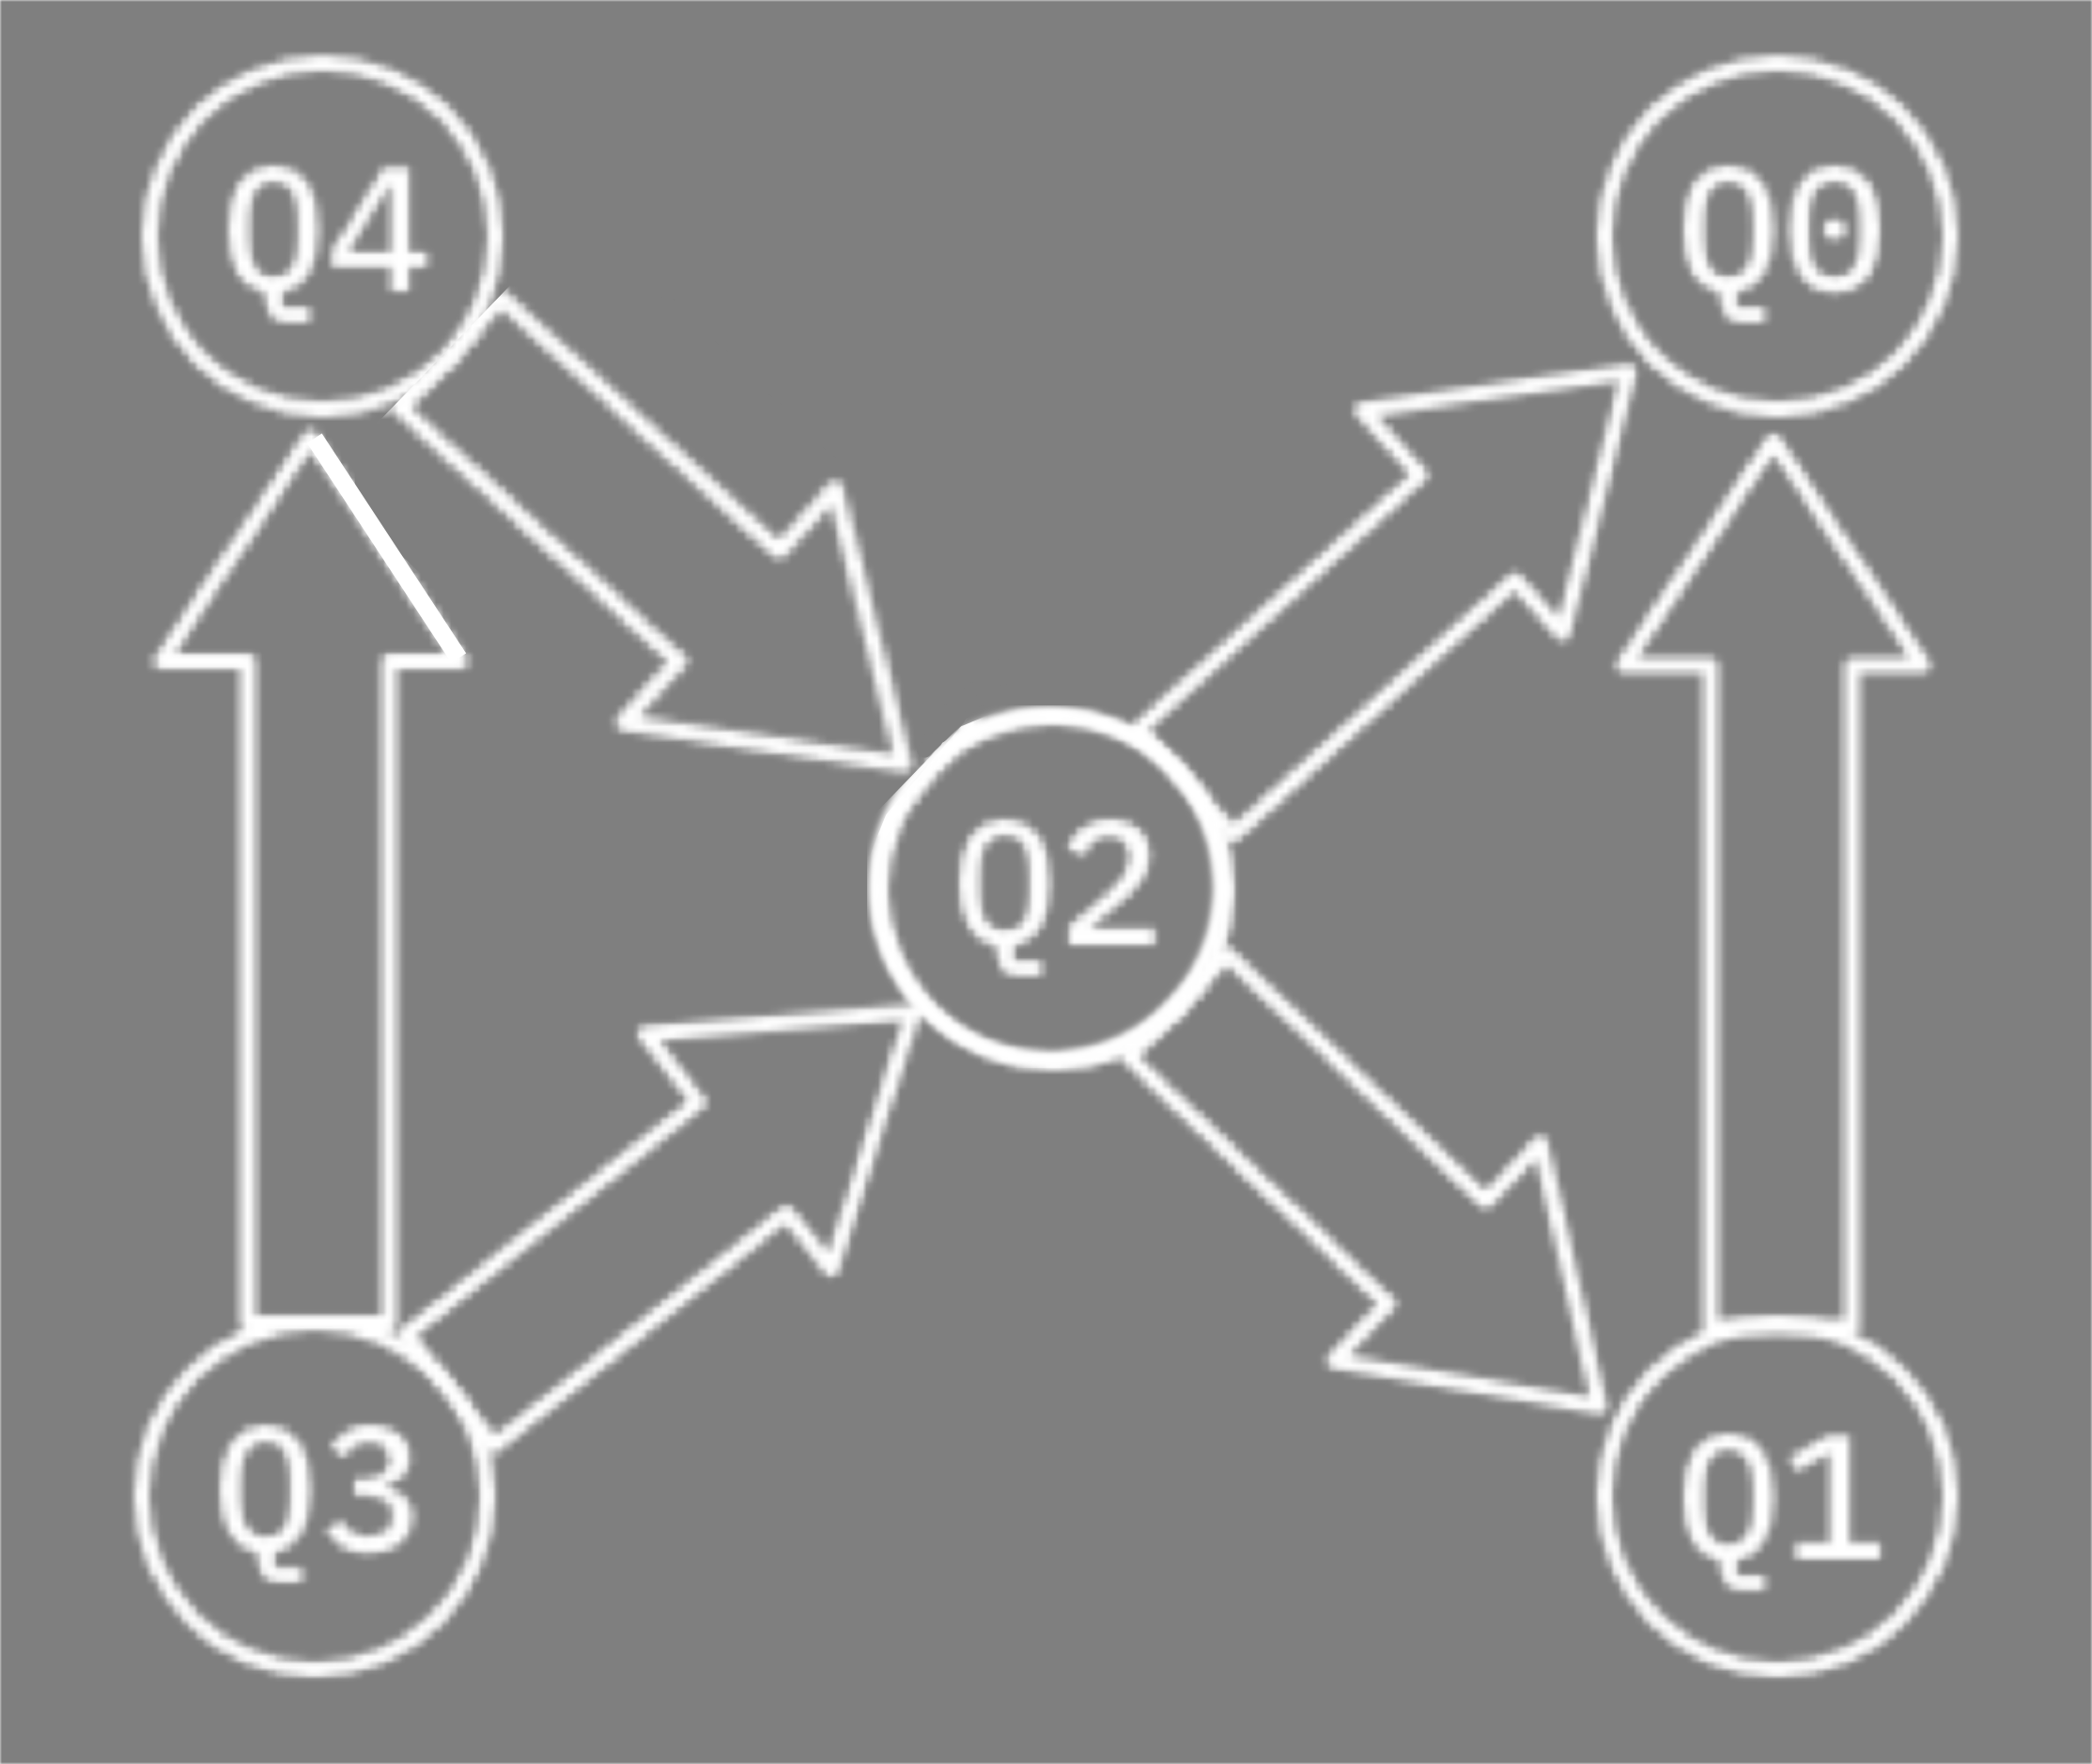

* <p style='text-align: justify;'> **Exercise 2.10** Run as many of the examples and the exercises in this tutorial as you can on IBMQ quantum processors, adapting the circuits whenever needed or possible and choosing the most appropriate mapping on the physical qubits. Check in particular how the quality of the results is affected by the number of Suzuki-Trotter steps in your digital quantum simulations.</p>